In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = 'metro_heat_index.csv'
data = pd.read_csv(file_path)

# Encode 'StateName'
label_encoder = LabelEncoder()
data["StateName"] = label_encoder.fit_transform(data["StateName"])

# long format for time-series modeling
# https://stackoverflow.com/questions/2185252/reshaping-data-frame-from-wide-to-long-format
# https://www.geeksforgeeks.org/python-pandas-melt/
data_long = data.melt(
    id_vars=["RegionID", "SizeRank", "StateName"],
    value_vars=[col for col in data.columns if col not in ["RegionID", "SizeRank", "StateName", "RegionName", "RegionType"]],
    var_name="Date",
    value_name="HeatIndex"
)

# Drop rows with missing or non-numeric target values
data_long = data_long.dropna(subset=["HeatIndex"])
data_long["HeatIndex"] = pd.to_numeric(data_long["HeatIndex"], errors="coerce")
"""
# forward fill missing values, last value is logical in use case
data_long["HeatIndex"] = data_long["HeatIndex"].ffill()
"""
# Convert the 'Date' column to datetime for sorting
data_long["Date"] = pd.to_datetime(data_long["Date"])

# write clean data to csv
data_long.to_csv("clean_metro_heat_index.csv", index=False)

# https://www.geeksforgeeks.org/numpy-quantile-in-python/
# Split the dataset over time .8 train, .2 test
split_date = data_long["Date"].quantile(0.8)
train_data = data_long[data_long["Date"] <= split_date]
test_data = data_long[data_long["Date"] > split_date]

# training and testing features and target
X_train = train_data[["RegionID", "SizeRank", "StateName"]]
y_train = train_data["HeatIndex"]
X_test = test_data[["RegionID", "SizeRank", "StateName"]]
y_test = test_data["HeatIndex"]



""""
# scale the features
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
"""



"""""
# heat index for orlando
orlando_data = data[(data["RegionName"] == "Orlando, FL") & (data["StateName"] == label_encoder.transform(["FL"])[0])]
orlando_features = orlando_data[["RegionID", "SizeRank", "StateName"]]
orlando_prediction = random_forest.predict(orlando_features)

# overall mean heat index
overall_mean_heat_index = data_long["HeatIndex"].mean()

# last heat index value for Orlando
orlando_last_heat_index = orlando_data.iloc[:, -1].values[0]

# predicted heat index > the last heat index
is_orlando_higher = orlando_prediction.mean() > orlando_last_heat_index

# results
print("Predicted Heat Index:", orlando_prediction.mean())
print("Mean Heat Index:", overall_mean_heat_index)
print("Last Heat Index:", orlando_last_heat_index)
print("Heat Index Higher?", is_orlando_higher)
"""


'""\n# heat index for orlando\norlando_data = data[(data["RegionName"] == "Orlando, FL") & (data["StateName"] == label_encoder.transform(["FL"])[0])]\norlando_features = orlando_data[["RegionID", "SizeRank", "StateName"]]\norlando_prediction = random_forest.predict(orlando_features)\n\n# overall mean heat index\noverall_mean_heat_index = data_long["HeatIndex"].mean()\n\n# last heat index value for Orlando\norlando_last_heat_index = orlando_data.iloc[:, -1].values[0]\n\n# predicted heat index > the last heat index\nis_orlando_higher = orlando_prediction.mean() > orlando_last_heat_index\n\n# results\nprint("Predicted Heat Index:", orlando_prediction.mean())\nprint("Mean Heat Index:", overall_mean_heat_index)\nprint("Last Heat Index:", orlando_last_heat_index)\nprint("Heat Index Higher?", is_orlando_higher)\n'

In [ ]:
# write clean data to csv
# data_long.to_csv("clean_metro_heat_index.csv", index=False)

In [3]:
# Train the model
# Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 500}
random_forest = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=10, min_samples_split=10)
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=500,
                      random_state=42)

In [4]:
def location_heat_index_prediction(location, dataset, model):
    """
    Predict the heat index for location

    parameters
    ----------
    location : str
    dataset : pd.DataFrame
        cleaned and parsed dataset
    model : RandomForestRegressor
        trained Random Forest model

    Returns
    -------
    float
        The predicted heat index for the given location
    """
    
    # Get the data for the given location
    location_data = dataset[dataset["RegionName"] == location]
    location_features = location_data[["RegionID", "SizeRank", "StateName"]]

    # Predict the heat index
    location_prediction = model.predict(location_features)

    return location_prediction.mean()

def last_heat_index(location, dataset):
    """
    Get the last heat index for location

    parameters
    ----------
    location : str
    dataset : pd.DataFrame
        cleaned and parsed dataset

    Returns
    -------
    float
        The last heat index for the given location
    """
    
    # Get the data for the given location
    location_data = dataset[dataset["RegionName"] == location]

    # Get the last heat index
    location_last_heat_index = location_data.iloc[:, -1].values[0]

    return location_last_heat_index

orlando_prediction = location_heat_index_prediction("Orlando, FL", data, random_forest)
print("Predicted Heat Index:", orlando_prediction)

orlando_last_heat_index = last_heat_index("Orlando, FL", data)
print("Last Heat Index:", orlando_last_heat_index)


Predicted Heat Index: 57.78211379762442
Last Heat Index: 44.0


In [5]:
def test_accuracy(model, X_test, y_test):

    # Predict the heat index for the test data
    y_pred = model.predict(X_test)

    # Calculate the mean squared error of the model on the test data
    mse = mean_squared_error(y_test, y_pred)

    return mse

test_error = test_accuracy(random_forest, X_test, y_test)
print("Test Error:", test_error)

Test Error: 290.1928333757916


In [6]:
import matplotlib.pyplot as plt

def plot_predictions(model, X_test, y_test):
    # Predict the heat index for the test data
    y_pred = model.predict(X_test)

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Heat Index')
    plt.ylabel('Predicted Heat Index')
    plt.title('Actual vs Predicted Heat Index')
    plt.show()



In [7]:
# hyperparameter tuning
# https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

from sklearn.model_selection import GridSearchCV

# parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 500],
    'max_depth': [None, 10, 20, 40, 100],
    'min_samples_split': [2, 5, 10, 15, 20]
}

grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)


grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


KeyboardInterrupt: 

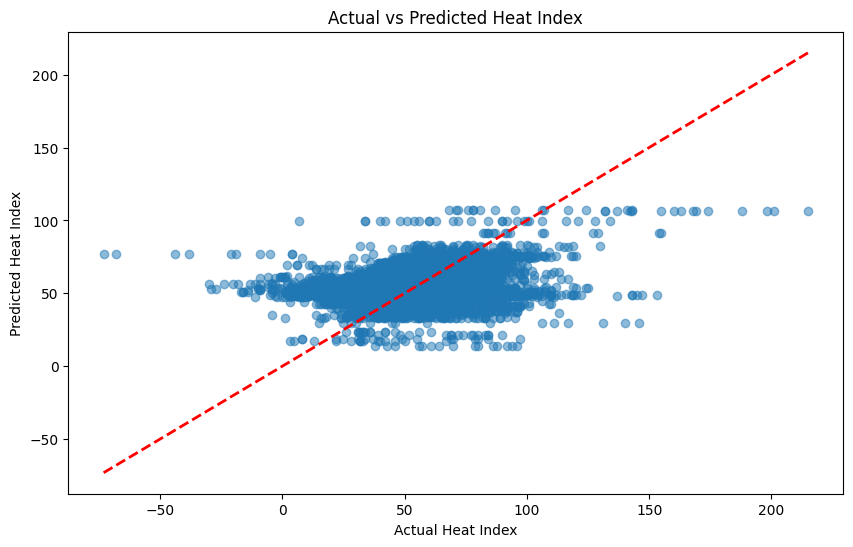

290.1928333757916

In [8]:
plot_predictions(random_forest, X_test, y_test)
test_accuracy(random_forest, X_test, y_test)